# Stock market forecasting using Time Series analysis

**Here the closing stock price of Nifty 100 stock is optimized using ARIMA model**

### Loading all the required libraries

In [1]:
!pip install pmdarima

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [3]:
import yfinance as yf
stock_data = yf.download('^N100', start='2023-01-01', end='2023-08-15')
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,1232.619995,1252.880005,1232.619995,1252.020020,1252.020020,0
2023-01-03,1251.979980,1272.939941,1251.449951,1257.359985,1257.359985,172781700
2023-01-04,1257.689941,1279.670044,1257.689941,1279.099976,1279.099976,217367800
2023-01-05,1278.390015,1281.300049,1272.859985,1275.729980,1275.729980,178555500
2023-01-06,1275.890015,1294.349976,1275.060059,1294.310059,1294.310059,153096200
...,...,...,...,...,...,...
2023-08-08,1367.530029,1367.530029,1349.130005,1357.319946,1357.319946,597186900
2023-08-09,1358.359985,1376.709961,1358.359985,1367.550049,1367.550049,374827300
2023-08-10,1368.310059,1388.400024,1368.310059,1382.880005,1382.880005,294858300


In [4]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,1232.619995,1252.880005,1232.619995,1252.020020,1252.020020,0
2023-01-03,1251.979980,1272.939941,1251.449951,1257.359985,1257.359985,172781700
2023-01-04,1257.689941,1279.670044,1257.689941,1279.099976,1279.099976,217367800
2023-01-05,1278.390015,1281.300049,1272.859985,1275.729980,1275.729980,178555500
2023-01-06,1275.890015,1294.349976,1275.060059,1294.310059,1294.310059,153096200
...,...,...,...,...,...,...
2023-08-08,1367.530029,1367.530029,1349.130005,1357.319946,1357.319946,597186900
2023-08-09,1358.359985,1376.709961,1358.359985,1367.550049,1367.550049,374827300
2023-08-10,1368.310059,1388.400024,1368.310059,1382.880005,1382.880005,294858300


In [5]:
df_close  = stock_data.Close
if df_close.isna().sum() > 0:
    df_close = df_close.fillna(method='ffill')

Visualizing the per day closing price of the stock.

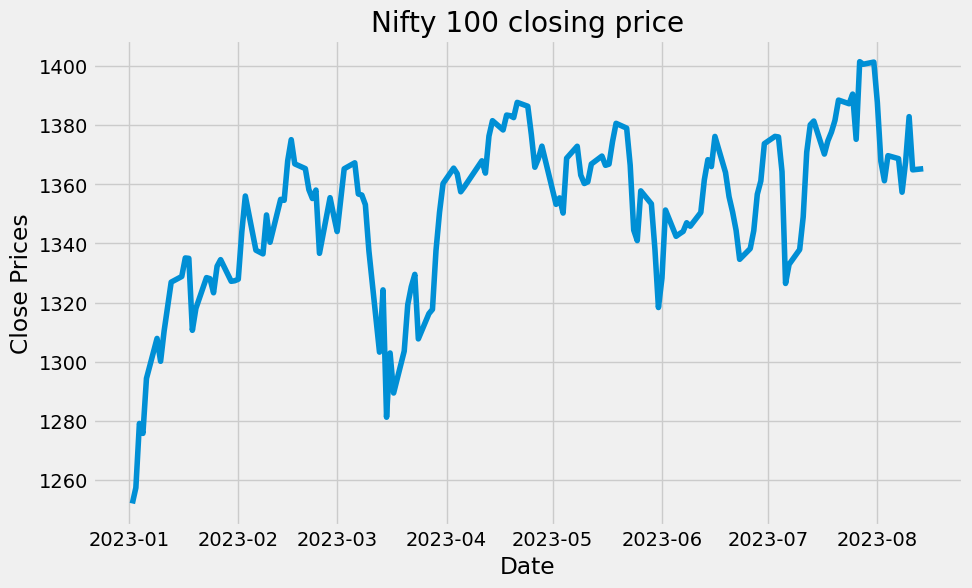

In [6]:
#plotting the close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Nifty 100 closing price')
plt.show()

In [7]:
# using the dickey-fuller test to check the stationarity in the time series
def test_stationarity(df_close):
    # Checking for stationarity
    adf = adfuller(df_close)

    for key, value in adf[4].items():
        print(f"  {key}: {value}")

    if adf[1] < 0.05:
        print('The data is stationary')
    else:
        print('The data is not stationary')


In [8]:
test_stationarity(df_close)

  1%: -3.472703119504854
  5%: -2.880131672353732
  10%: -2.5766826861130268
The data is stationary


<Figure size 1000x600 with 0 Axes>

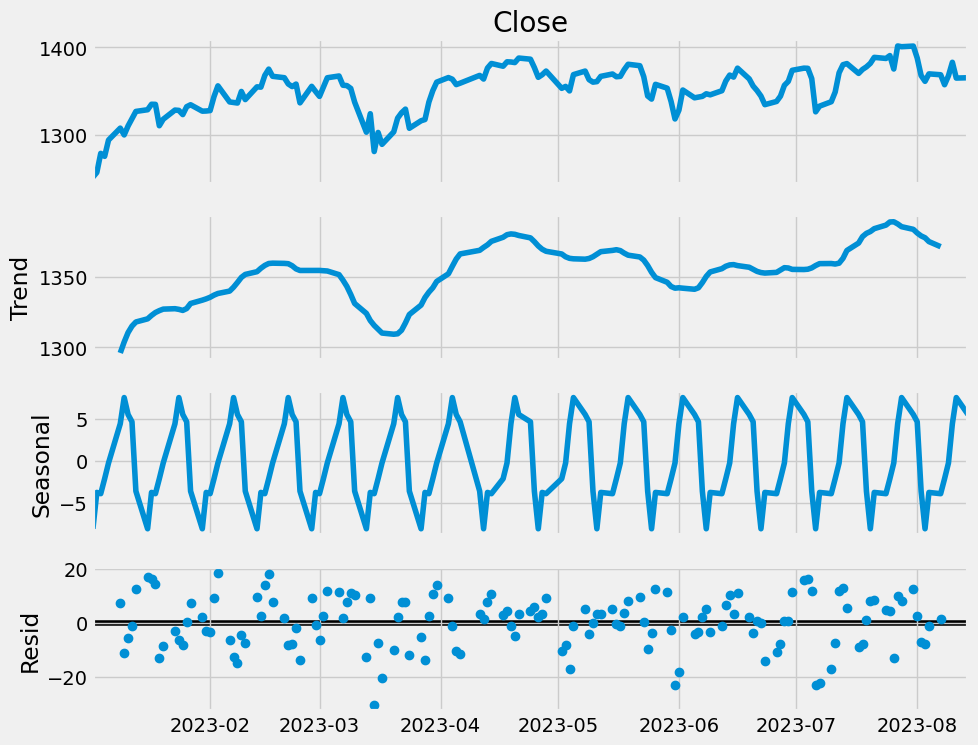

In [9]:
# separating the trend and the seasonality from a time series,
# decomposing the time series .
result = seasonal_decompose(df_close, period=10 ,model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


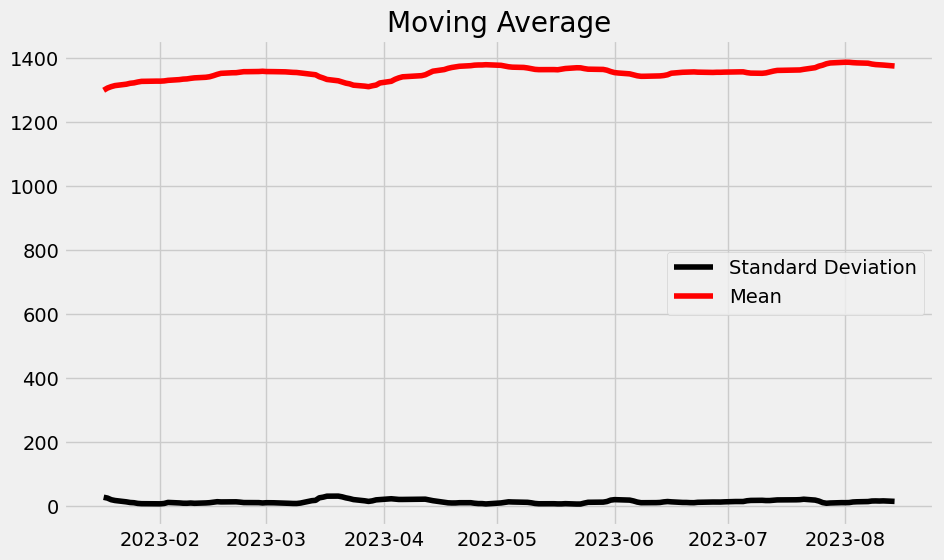

In [10]:
#Eliminating trend using moving Average and SD
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = df_close
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now creating an ARIMA model and will train it with the closing price of the stock on the train data. First splitting the data into training and test set.

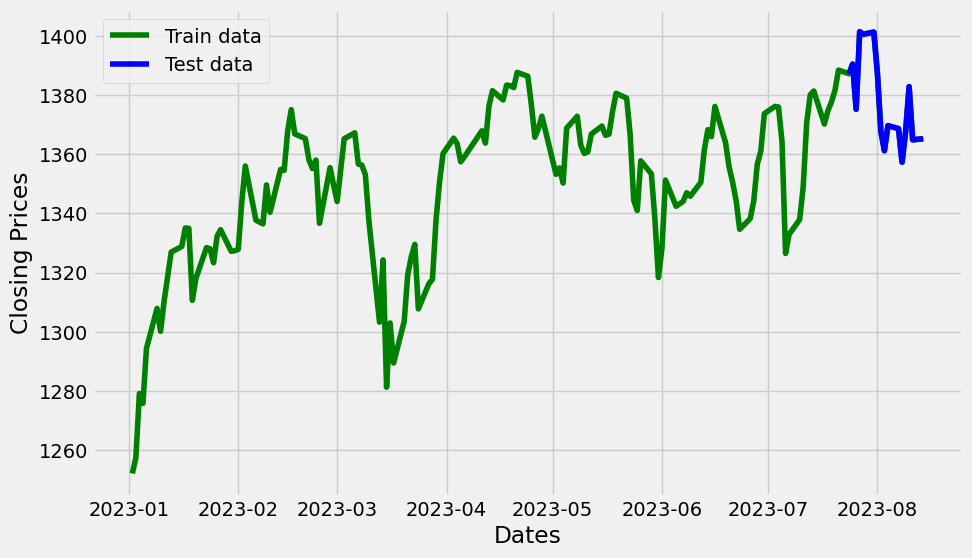

In [11]:
#splitting data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):] #applying log transform for better correlation
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Now chosing the parameters p,q,d for ARIMA model. Using the Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1069.194, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1070.680, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1070.726, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1067.891, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1071.977, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  139
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -532.946
Date:                Sun, 03 Sep 2023   AIC                           1067.891
Time:                        22:39:39   BIC                           1070.818
Sample:                             0   HQIC                          1069.081
                                - 139                                       

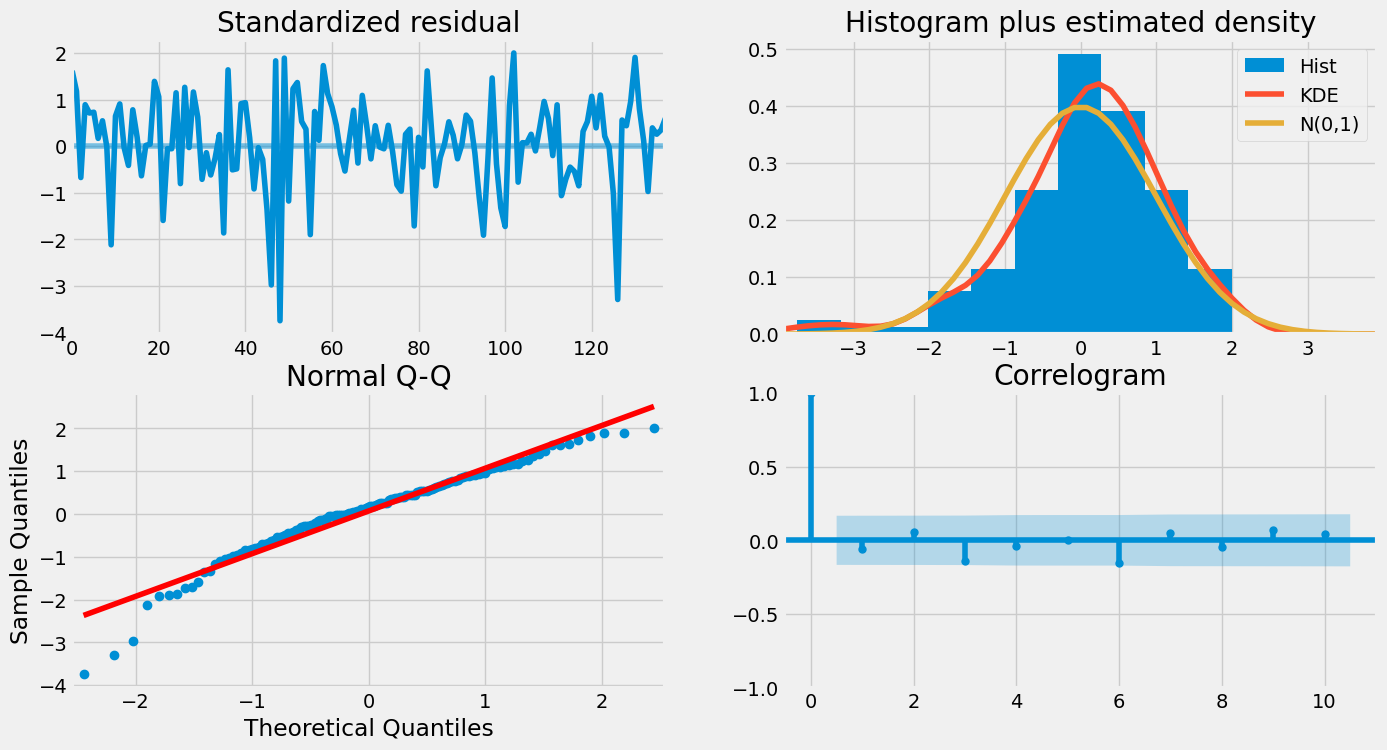

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # using the adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Auto ARIMA model provided the value of p,d, and q and using these values to train the arima model.**

In [13]:
#training the Arima Model with Order (p , d , q)

def train(df_close , p , d , q):

  model = ARIMA(df_close ,order=(p, d, q))
  model = model.fit()
  return model

model = ARIMA(df_log, order=model_autoARIMA.order)
model = model.fit()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### forecasting the stock prices on the test dataset keeping 95% confidence level.

In [14]:
# Forecasting the p,d,f values obtained from the above

p = 1
q = 5
d = 2
model = train(df_close.values , p , d , q)
fc = model.forecast(321, alpha=0.05)  # 95% conf

Plotting the results

In [15]:
# Making as a pandas series

fc = model.forecast(len(test_data), alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
fc_series

Date
2023-07-24    1364.193894
2023-07-25    1365.955256
2023-07-26    1369.359793
2023-07-27    1367.469092
2023-07-28    1370.527647
2023-07-31    1369.062431
2023-08-01    1371.732080
2023-08-02    1370.622337
2023-08-03    1372.967072
2023-08-04    1372.154310
2023-08-07    1374.227596
2023-08-08    1373.662946
2023-08-09    1375.509450
2023-08-10    1375.152086
2023-08-11    1376.809124
2023-08-14    1376.624938
dtype: float64

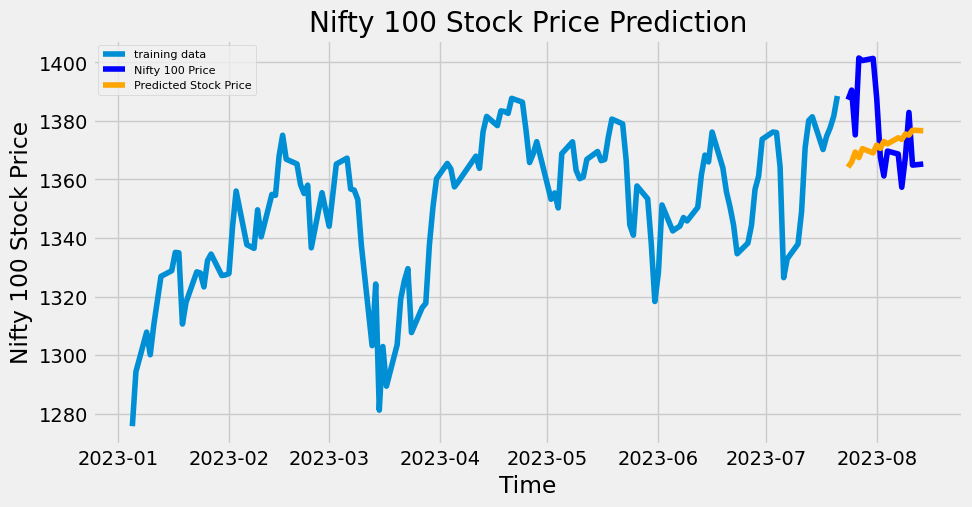

In [16]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Nifty 100 Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('Nifty 100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nifty 100 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

checking the commonly used accuracy metrics to judge forecast results:

In [17]:
#Calculating the RMSE and Absolute error using Scikit Learn Function

rmse = np.sqrt(mean_squared_error(test_data, fc_series))
mae = mean_absolute_error(test_data, fc_series)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 18.32429196913695
Mean Absolute Error (MAE): 15.234711040173735
